In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [4]:
train.describe(include = ['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [5]:
train.HomePlanet.value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [6]:
train.Destination.value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
train.Age.max()

79.0

In [9]:
train.Destination.value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

<Axes: xlabel='Transported'>

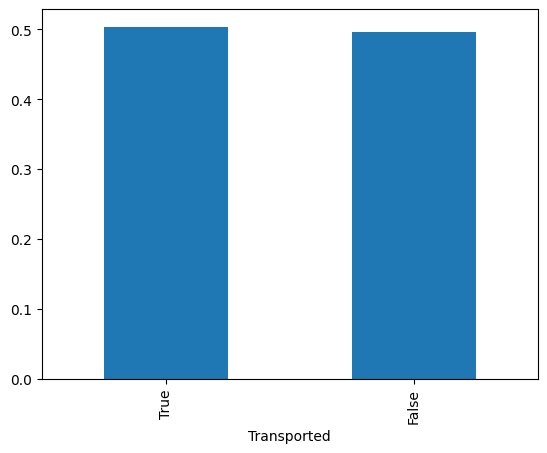

In [10]:
trainplt = train.Transported.value_counts(normalize=True)
trainplt.plot(kind="bar")

In [11]:
print(trainplt)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


<Axes: xlabel='HomePlanet', ylabel='Transported'>

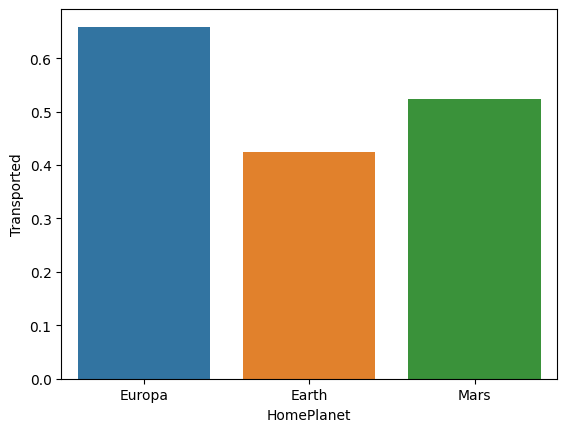

In [12]:
sns.barplot(x="HomePlanet", y="Transported", data=train, errorbar=None)

<Axes: xlabel='CryoSleep'>

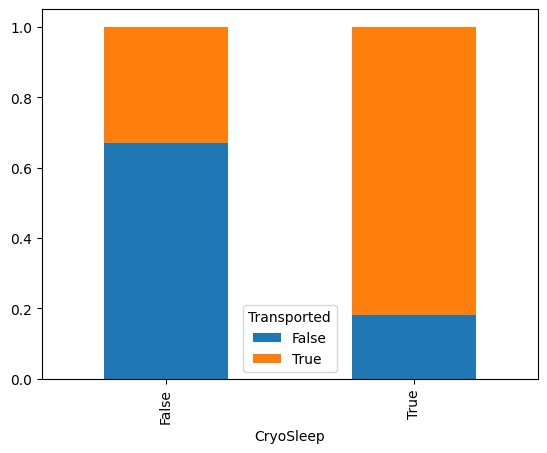

In [13]:
tab = pd.crosstab(train["CryoSleep"], train["Transported"])
tab.div(tab.sum(1), axis=0).plot(kind="bar", stacked=True)

<Axes: xlabel='Destination', ylabel='Transported'>

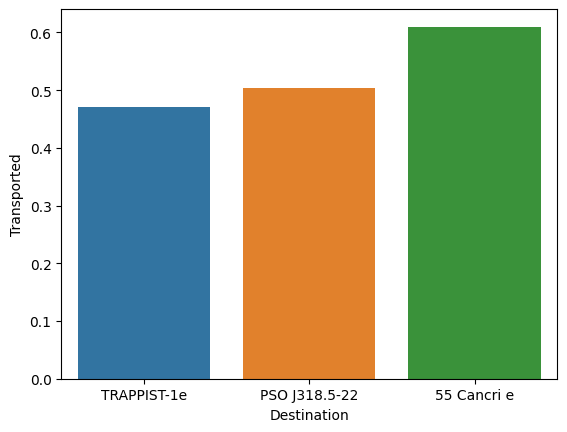

In [14]:
sns.barplot(x="Destination", y="Transported", data=train, errorbar=None)

<Axes: xlabel='VIP'>

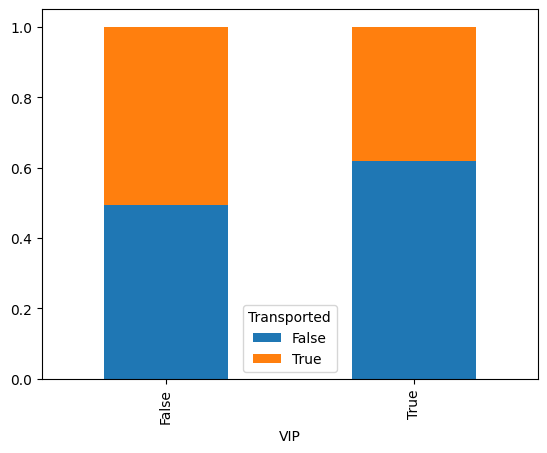

In [15]:
tab = pd.crosstab(train["VIP"], train["Transported"])
tab.div(tab.sum(1), axis=0).plot(kind="bar", stacked=True)

In [16]:
trt = [train, test]
for t in trt:
    t["Board"] = t.Cabin.str.extract("(.)$")
    t["Deck"] = t.Cabin.str.extract("^(.+?)/")
    t["CabNum"] = t.Cabin.str.extract("/(.+?)/")
    # t.drop(["Cabin", "Name"], axis=1, inplace=True)
# train.drop("Cabin", axis=1, inplace=True)
# test.drop("Cabin", axis=1, inplace=True)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Board,Deck,CabNum
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,P,B,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,S,F,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,S,A,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,S,A,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,S,F,1


In [17]:
print(train.Deck.value_counts())
print(train.CabNum.value_counts())
for t in trt:
    t.fillna({"CabNum": train.CabNum.mode()[0]}, inplace=True)
    t.CabNum = t.CabNum.astype(int)
print(train.CabNum.isnull().sum())

Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64
CabNum
82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: count, Length: 1817, dtype: int64
0


In [18]:
tr_survived = train[train["Transported"] == True]
tr_notsur = train[train["Transported"] == False]

<Axes: xlabel='Board', ylabel='Transported'>

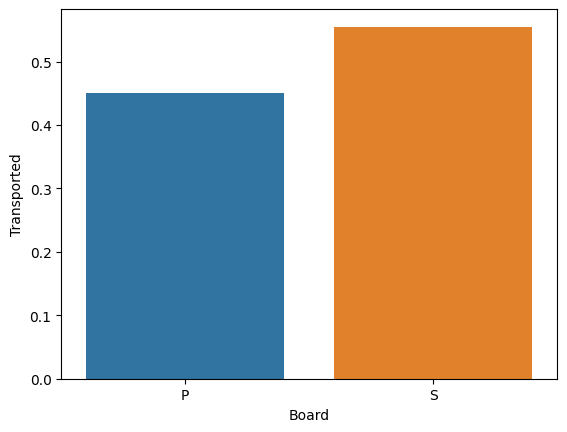

In [19]:
sns.barplot(x="Board", y="Transported", data=train, errorbar=None)

<Axes: xlabel='Deck', ylabel='Transported'>

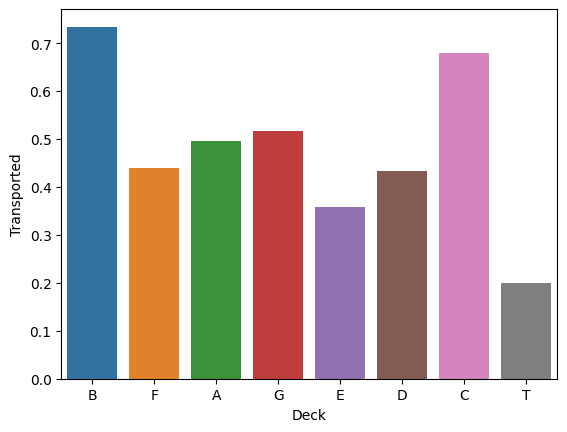

In [20]:
sns.barplot(x="Deck", y="Transported", data=train, errorbar=None)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


37.86


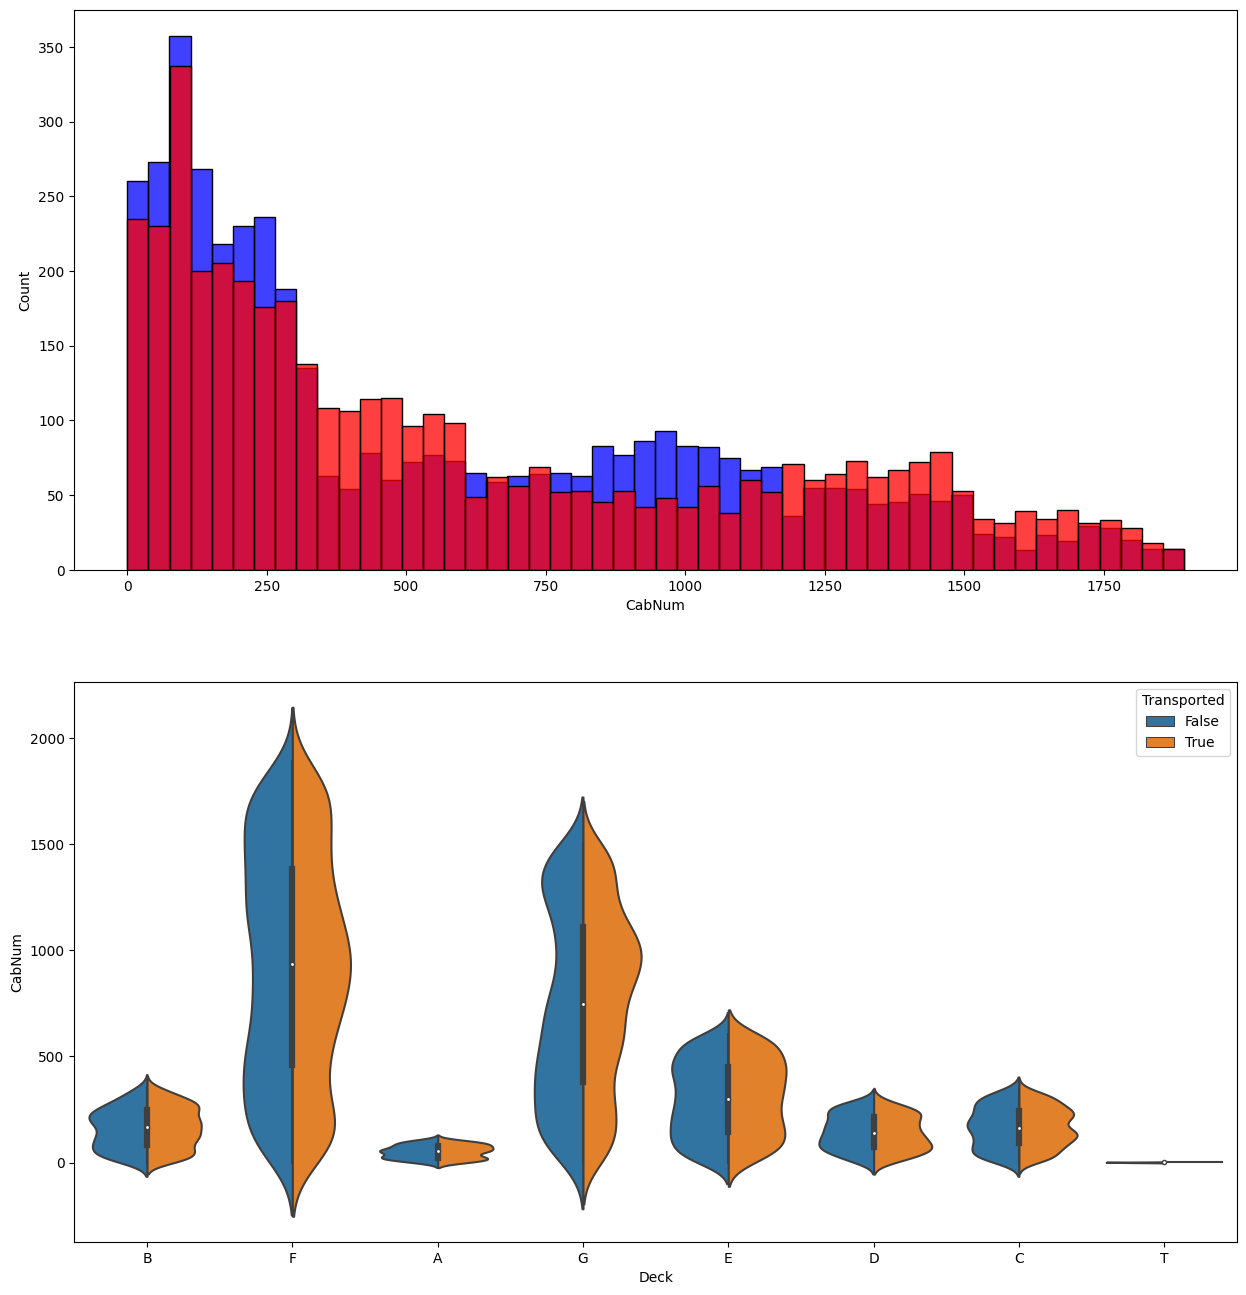

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(15, 16))
sns.histplot(tr_survived.CabNum, color="blue", bins=50, ax=ax[0])
h = sns.histplot(tr_notsur.CabNum, color="red", bins=50, ax=ax[0])
sns.violinplot(x="Deck", y="CabNum", hue="Transported", data=train, split=True, ax=ax[1])
print(h.patches[0].get_width())

In [22]:
board_mapping = {"P": 0, "S": 1}
deck_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7}
for t in trt:
    t.Board = t.Board.map(board_mapping)
    t.Deck = t.Deck.map(deck_mapping)
    t["CNB"] = np.floor(t.CabNum/37.86)

заполним рандомными числами 0 или 1 пропуски в Board, а пропуски в Deck заполним рандомными значениями b или c

In [23]:
for t in trt:
    t.loc[t.Board.isnull(), "Board"] = np.random.randint(0, 1, t.Board.isnull().sum())
    t.loc[t.Deck.isnull(), "Deck"] = np.random.randint(1, 2, t.Deck.isnull().sum())
    t.Board = t.Board.astype(int)
    t.Deck = t.Deck.astype(int)
    t.CNB = t.CNB.astype(int)

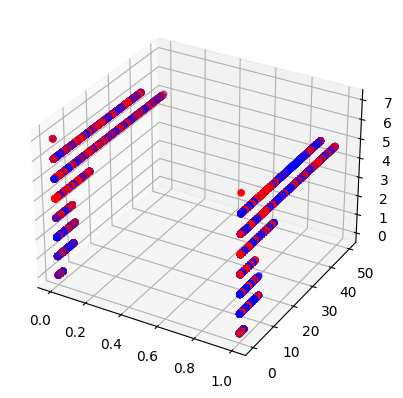

In [24]:
color_mapping = {True: "blue", False: "red"}
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(train.Board, train.CNB, train.Deck, c=train.Transported.map(color_mapping))

In [25]:
for t in trt:
    t["GroupNum"] = t.PassengerId.str.extract("^(\d\d\d\d)")
    t["PeopleNum"] = t.GroupNum.map(t.groupby("GroupNum").size())
    t.drop(["CNB", "GroupNum"], axis=1, inplace=True)
train.head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Board,Deck,CabNum,PeopleNum
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0,1,0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,5,0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,0,0,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1,0,0,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,5,1,1
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,0,5,0,1
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,1,5,2,2
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,1,6,0,2
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,1,5,3,1
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,0,1,1,3


<Axes: xlabel='PeopleNum', ylabel='Transported'>

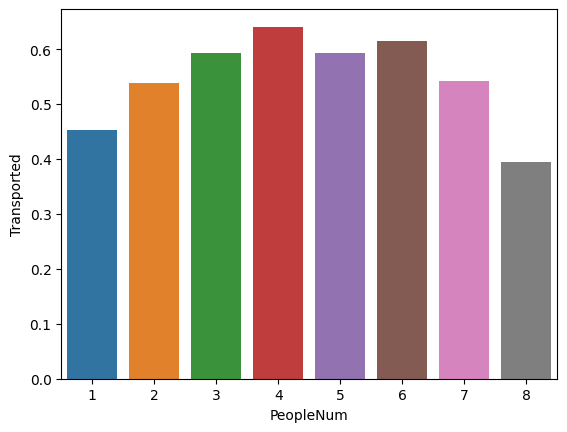

In [26]:
sns.barplot(x="PeopleNum", y="Transported", data=train, errorbar=None)

In [27]:
train.groupby("PeopleNum")["Transported"].value_counts()

PeopleNum  Transported
1          False          2631
           True           2174
2          True            905
           False           777
3          True            605
           False           415
4          True            264
           False           148
5          True            157
           False           108
6          True            107
           False            67
7          True            125
           False           106
8          False            63
           True             41
Name: count, dtype: int64

44.73
55.27


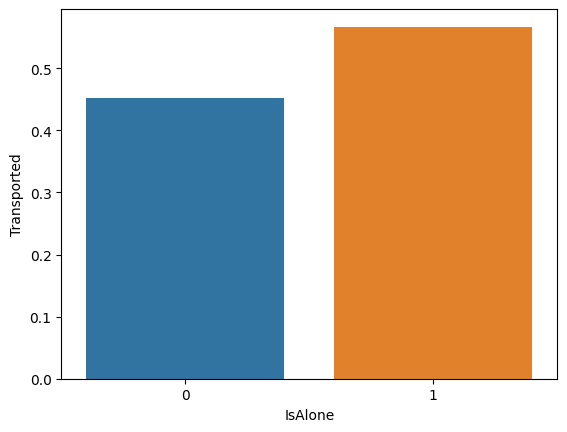

In [28]:
for t in trt:
    t["IsAlone"] = 0
    t.loc[t["PeopleNum"] > 1, "IsAlone"] = 1
sns.barplot(x="IsAlone", y="Transported", data=train, errorbar=None)
print("%2.2f"%(train[train["IsAlone"] == 1].size/train.size*100))
print("%2.2f"%(train[train["IsAlone"] == 0].size/train.size*100))

In [29]:
bool_mapping = {True: 1, False: 0}
for t in trt:
    t.VIP = t.VIP.map(bool_mapping)
    t.CryoSleep = t.CryoSleep.map(bool_mapping)
train.Transported = train.Transported.map(bool_mapping).astype(int)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Board,Deck,CabNum,PeopleNum,IsAlone
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,1,0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,5,0,1,0
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,0,0,2,1
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,1,0,0,2,1
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,5,1,1,0


In [30]:
for t in trt:
    m = t.Age.mean()
    s = t.Age.std()
    c = t.Age.isnull().sum()
    rv = np.random.randint(m-s, m+s, c)
    t.loc[t.Age.isnull(), "Age"] = rv
    t.Age = t.Age.astype(int)
    t["AgeBand"] = pd.cut(t.Age, 5)
print(test.AgeBand.value_counts())

AgeBand
(15.8, 31.6]      2120
(31.6, 47.4]      1139
(-0.079, 15.8]     573
(47.4, 63.2]       382
(63.2, 79.0]        63
Name: count, dtype: int64


In [31]:
for t in trt:
    t.loc[t.Age <= 15.8, "Age"] = 0
    t.loc[(t.Age > 15.8) & (t.Age <= 31.6), "Age"] = 1
    t.loc[(t.Age > 31.6) & (t.Age <= 47.4), "Age"] = 2
    t.loc[(t.Age > 47.4) & (t.Age <= 63.2), "Age"] = 3
    t.loc[t.Age > 63.2, "Age"] = 4
    t.Age = t.Age.astype(int)
    t.drop("AgeBand", axis=1, inplace=True)
train.head(12)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Board,Deck,CabNum,PeopleNum,IsAlone
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,2,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,1,0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,1,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,5,0,1,0
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,3,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,0,0,2,1
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,2,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,1,0,0,2,1
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,1,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,5,1,1,0
5,0005_01,Earth,0.0,F/0/P,PSO J318.5-22,2,0.0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,1,0,5,0,1,0
6,0006_01,Earth,0.0,F/2/S,TRAPPIST-1e,1,0.0,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,1,1,5,2,2,1
7,0006_02,Earth,1.0,G/0/S,TRAPPIST-1e,1,0.0,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,1,1,6,0,2,1
8,0007_01,Earth,0.0,F/3/S,TRAPPIST-1e,2,0.0,0.0,785.0,17.0,216.0,0.0,Andona Beston,1,1,5,3,1,0
9,0008_01,Europa,1.0,B/1/P,55 Cancri e,0,0.0,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,1,0,1,1,3,1


In [32]:
for t in trt:
    # t.loc[t.CabNum < 303, "CabNum"] = 0
    # t.loc[(t.CabNum >= 303) & (t.CabNum < 606), "CabNum"] = 1
    # t.loc[(t.CabNum >= 31.6) & (t.CabNum < 1174), "CabNum"] = 2
    # t.loc[t.CabNum >= 1174, "CabNum"] = 3
    t.CabNum = t.CabNum.astype(int)
train.CabNum.value_counts()

CabNum
82      227
19       22
86       22
56       21
176      21
       ... 
1644      1
1515      1
1639      1
1277      1
1894      1
Name: count, Length: 1817, dtype: int64

201
182


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Board,Deck,CabNum,PeopleNum,IsAlone
0,0001_01,0,0.0,B/0/P,0,2,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,1,0
1,0002_01,1,0.0,F/0/S,0,1,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,5,0,1,0
2,0003_01,0,0.0,A/0/S,0,3,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,0,0,2,1
3,0003_02,0,0.0,A/0/S,0,2,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,1,0,0,2,1
4,0004_01,1,0.0,F/1/S,0,1,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,5,1,1,0


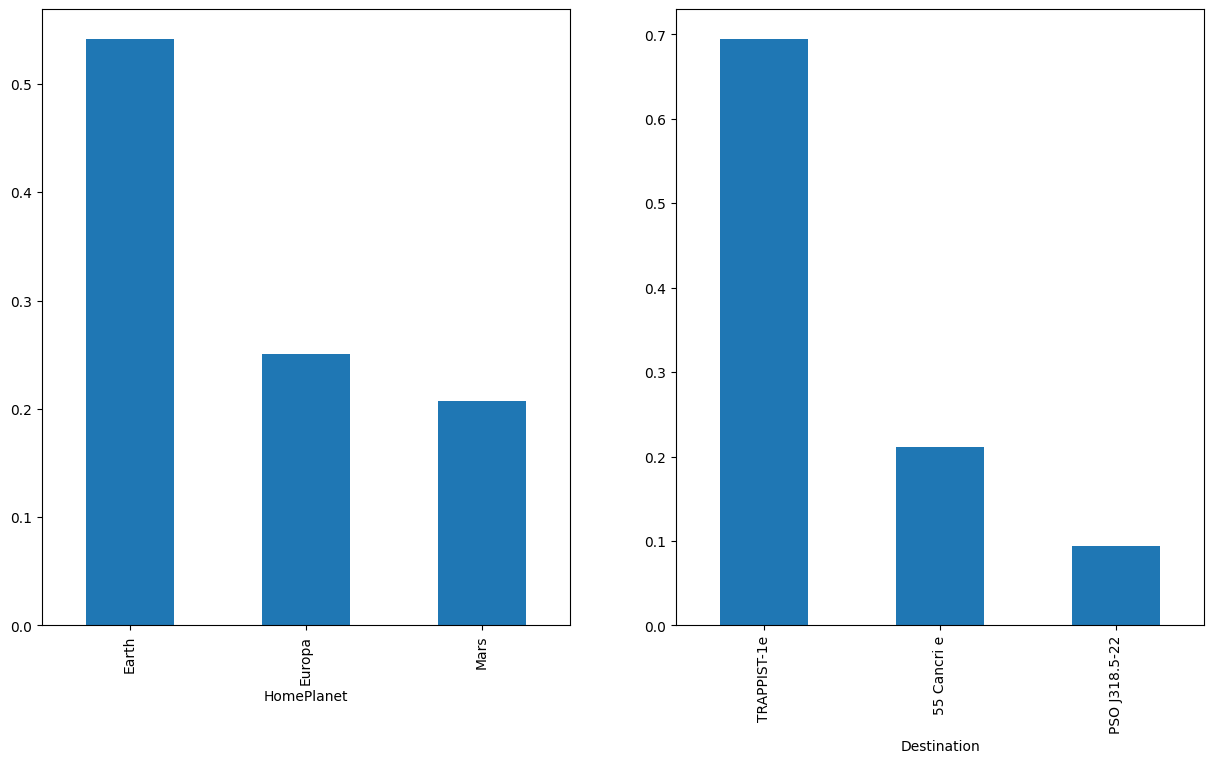

In [33]:
pl_mapping = {"Europa": 0, "Earth": 1, "Mars": 2}
d_mapping = {"TRAPPIST-1e": 0, "55 Cancri e": 1, "PSO J318.5-22": 2}
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
train.HomePlanet.value_counts(normalize=True).plot(kind="bar", ax=ax1)
train.Destination.value_counts(normalize=True).plot(kind="bar", ax=ax2)
print(train.HomePlanet.isnull().sum())
print(train.Destination.isnull().sum())
for t in trt:
    t.HomePlanet = t.HomePlanet.map(pl_mapping)
    t.Destination = t.Destination.map(d_mapping)
    t.fillna({"HomePlanet": 1}, inplace=True)
    t.fillna({"Destination": 0}, inplace=True)
    t.HomePlanet = t.HomePlanet.astype(int)
    t.Destination = t.Destination.astype(int)
train.head()

217
203
0


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Board,Deck,CabNum,PeopleNum,IsAlone
0,0001_01,0,0,B/0/P,0,2,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,1,0
1,0002_01,1,0,F/0/S,0,1,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,5,0,1,0
2,0003_01,0,0,A/0/S,0,3,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,0,0,2,1
3,0003_02,0,0,A/0/S,0,2,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,1,0,0,2,1
4,0004_01,1,0,F/1/S,0,1,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,5,1,1,0


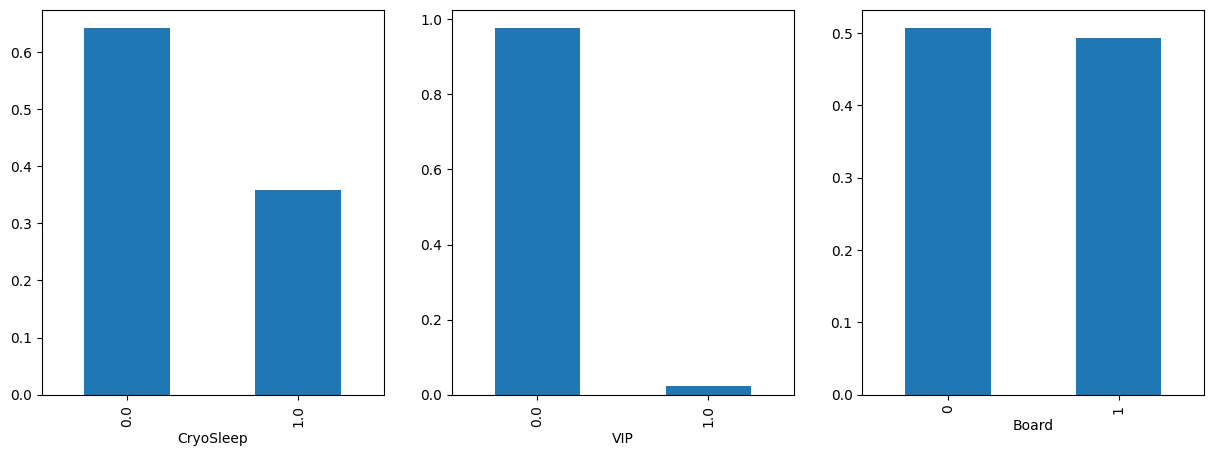

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

train.CryoSleep.value_counts(normalize=True).plot(kind="bar", ax=axes[0])
train.VIP.value_counts(normalize=True).plot(kind="bar", ax=axes[1])
train.Board.value_counts(normalize=True).plot(kind="bar", ax=axes[2])
print(train.CryoSleep.isnull().sum())
print(train.VIP.isnull().sum())
print(train.Board.isnull().sum())

for t in trt:
    t.fillna({"CryoSleep": 0, "VIP": 0}, inplace=True)
    t.CryoSleep = t.CryoSleep.astype(int)
    t.VIP = t.VIP.astype(int)
train.head()

In [51]:
train.groupby("Deck").VIP.value_counts()

Deck  VIP
0     0       221
      1        35
1     0       930
      1        48
2     0       706
      1        41
3     0       447
      1        31
4     0       861
      1        15
5     0      2765
      1        29
6     0      2559
7     0         5
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

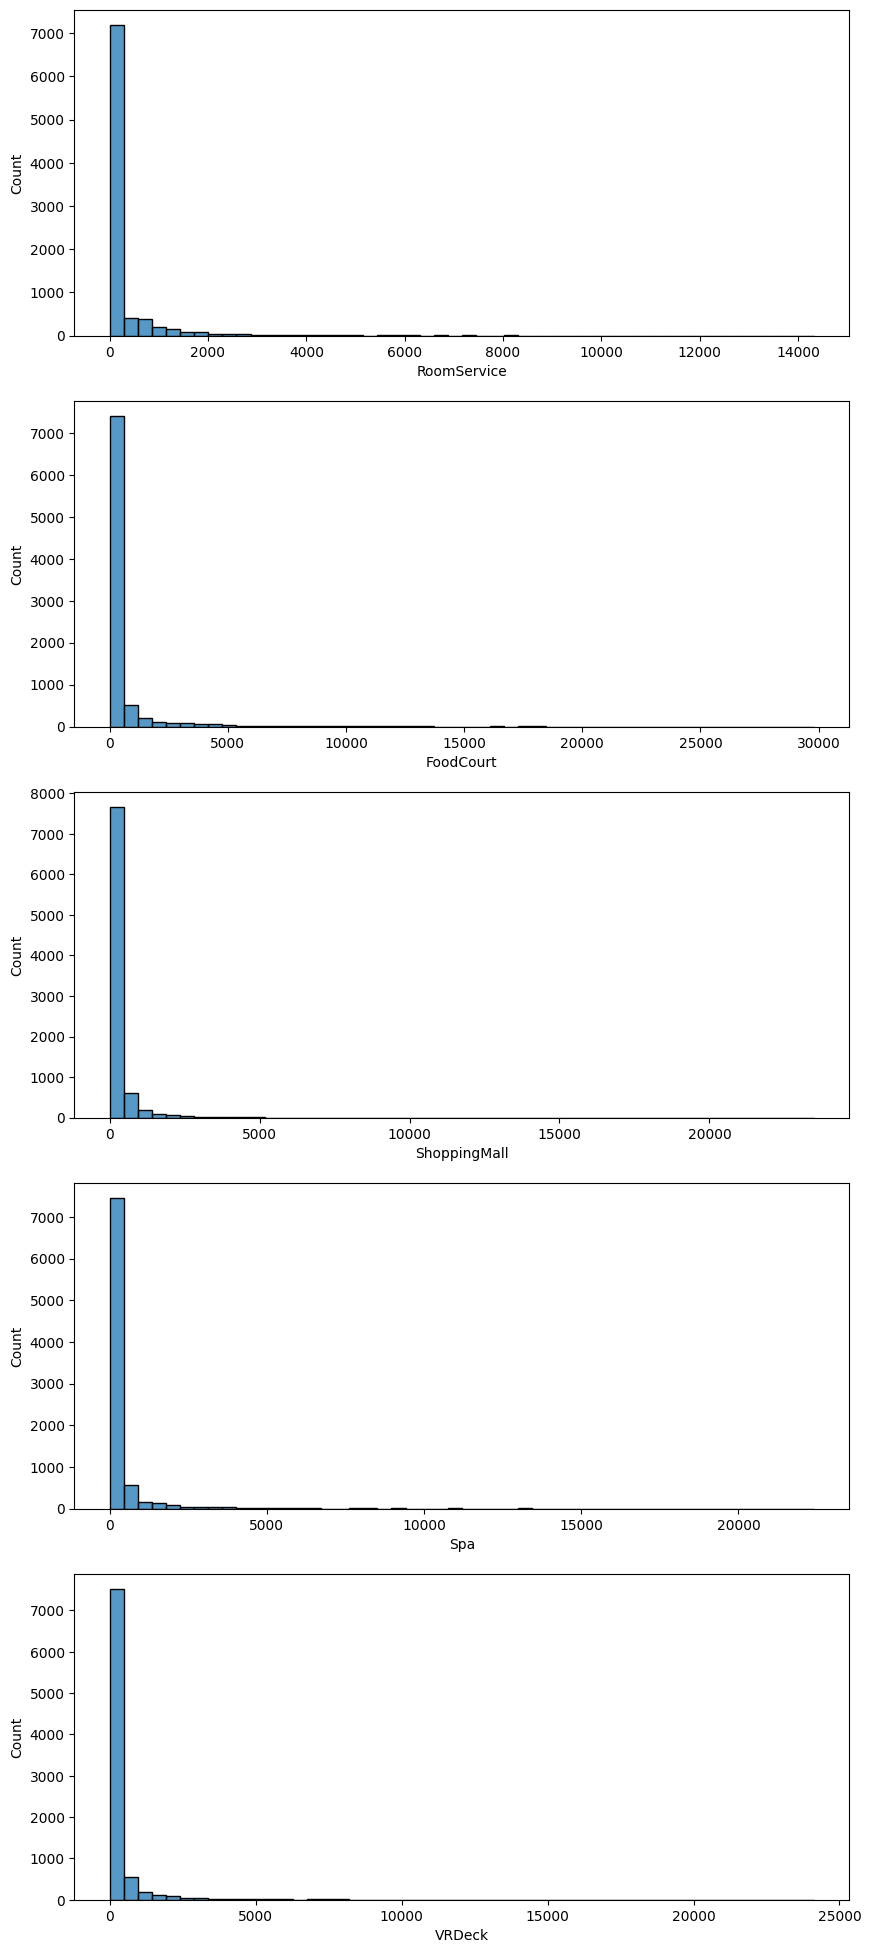

In [36]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)
for t in trt:
    t.fillna({"RoomService": 0, "FoodCourt": 0, "ShoppingMall": 0, "Spa": 0, "VRDeck": 0}, inplace=True)
sns.histplot(train['RoomService'], bins=50, ax=ax[0]);
sns.histplot(train['FoodCourt'], bins=50, ax=ax[1]);
sns.histplot(train['ShoppingMall'], bins=50, ax=ax[2]);
sns.histplot(train['Spa'], bins=50, ax=ax[3]);
sns.histplot(train['VRDeck'], bins=50, ax=ax[4]);

In [37]:
train.RoomService

0         0.0
1       109.0
2        43.0
3         0.0
4       303.0
        ...  
8688      0.0
8689      0.0
8690      0.0
8691      0.0
8692    126.0
Name: RoomService, Length: 8693, dtype: float64

<Axes: >

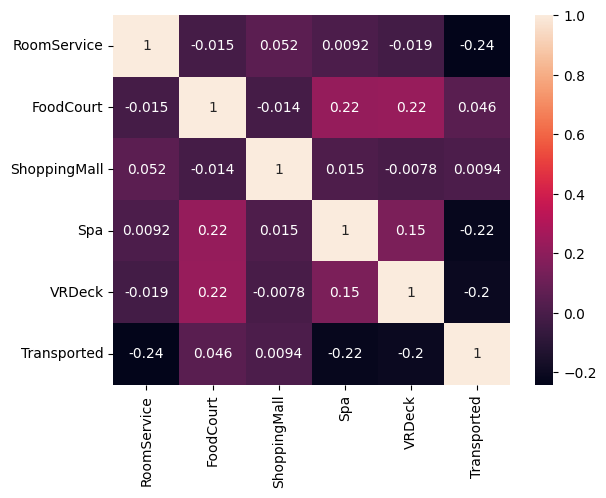

In [38]:
corr_matrix = train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported"]].corr()
sns.heatmap(corr_matrix, annot=True)

In [39]:
for t in trt:
    t.drop(["FoodCourt", "ShoppingMall"], axis=1, inplace=True)
fin_features = ["RoomService", "Spa", "VRDeck"]
scaler = MinMaxScaler()
train[fin_features] = scaler.fit_transform(train[fin_features])
test[fin_features] = scaler.transform(test[fin_features])
for t in trt:
    t["MoneySpent"] = (t.RoomService + t.Spa + t.VRDeck).astype(float)
    t.drop(fin_features, axis=1, inplace=True)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Name,Transported,Board,Deck,CabNum,PeopleNum,IsAlone,MoneySpent
0,0001_01,0,0,B/0/P,0,2,0,Maham Ofracculy,0,0,1,0,1,0,0.000000
1,0002_01,1,0,F/0/S,0,1,0,Juanna Vines,1,1,5,0,1,0,0.033931
2,0003_01,0,0,A/0/S,0,3,1,Altark Susent,0,1,0,0,2,1,0.304702
3,0003_02,0,0,A/0/S,0,2,0,Solam Susent,0,1,0,0,2,1,0.156560
4,0004_01,1,0,F/1/S,0,1,0,Willy Santantines,1,1,5,1,1,0,0.046446


In [40]:
train.groupby("CryoSleep").MoneySpent.mean()

CryoSleep
0    0.063489
1    0.000000
Name: MoneySpent, dtype: float64

In [41]:
# for t in trt:
#     t["MoneyBound"] = pd.cut(t.MoneySpent, 5)
# train.MoneyBound.value_counts()

In [42]:
# for t in trt:
#     t.loc[t.MoneySpent <= 0.249, "MoneySpent"] = 0
#     t.loc[t.MoneySpent > 0.995, "MoneySpent"] = 4
#     t.loc[(t.MoneySpent > 0.249) & (t.MoneySpent <= 0.498), "MoneySpent"] = 1
#     t.loc[(t.MoneySpent > 0.498) & (t.MoneySpent <= 0.747), "MoneySpent"] = 2
#     t.loc[(t.MoneySpent > 0.747) & (t.MoneySpent <= 0.995), "MoneySpent"] = 3
#     t.MoneySpent = t.MoneySpent.astype(int)
#     t.drop("MoneyBound", axis=1, inplace=True)
# train.MoneySpent.value_counts()

In [43]:
for t in trt:
    t.drop(["Cabin", "Name"], axis=1, inplace=True)

<Axes: >

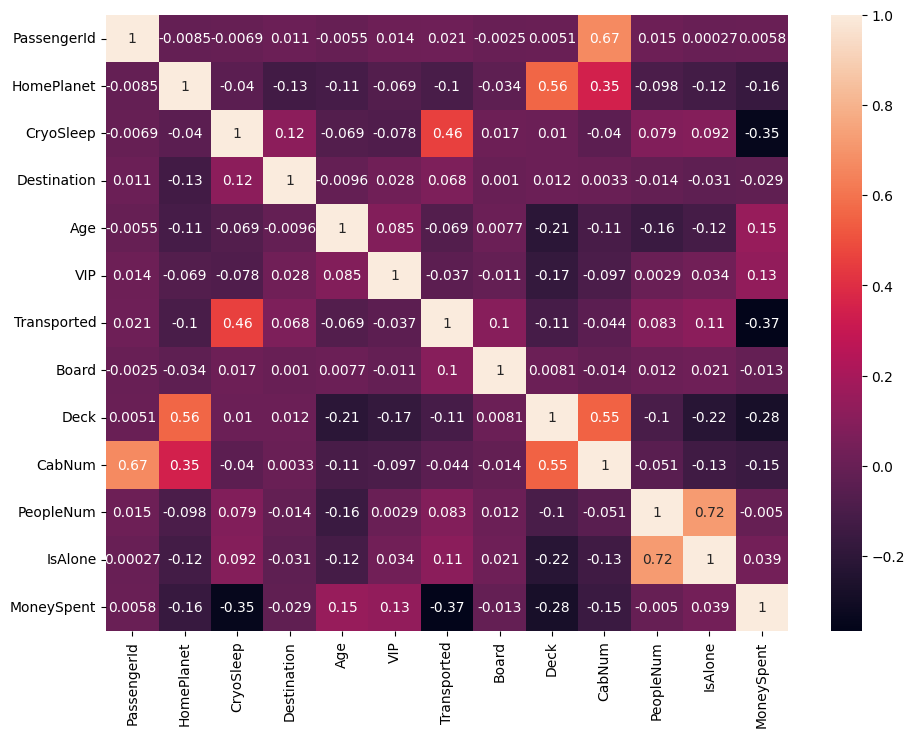

In [44]:
corr_matrix = train.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr_matrix, annot=True)

In [45]:
# for t in trt:
#     t.drop(["IsAlone"], axis=1, implace=True)

In [46]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Board,Deck,CabNum,PeopleNum,IsAlone,MoneySpent
0,0001_01,0,0,0,2,0,0,0,1,0,1,0,0.000000
1,0002_01,1,0,0,1,0,1,1,5,0,1,0,0.033931
2,0003_01,0,0,0,3,1,0,1,0,0,2,1,0.304702
3,0003_02,0,0,0,2,0,0,1,0,0,2,1,0.156560
4,0004_01,1,0,0,1,0,1,1,5,1,1,0,0.046446


In [47]:
x_train = train.drop(["PassengerId", "Transported"], axis=1)
y_train = train["Transported"]
x_test = test.drop("PassengerId", axis=1)

In [48]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(x_train, y_train)
y_test =  clf.predict(x_test)
print(round(clf.score(x_train, y_train)*100, 2))

99.32


In [49]:
res = pd.DataFrame({
    "PassengerId": test.PassengerId,
    "Transported": list(map(bool, y_test))
})
res.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [50]:
res.to_csv('submission.csv', index=False)